In [1]:
import time, datetime
import requests 
import pickle as pkl 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import json


import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


In [2]:
def query_prom(query, startTime, endTime, PROMETHEUS = 'http://20.71.55.156:9090/', debug=False):
    response = requests.get(PROMETHEUS + '/api/v1/query_range',
      params={'query': query,
              'start': startTime,
              'end': endTime,
              'step': '15s'})
    if debug:
        print(response.json())
    results = response.json()['data']['result']
    return results

In [3]:
from prometheus_api_client import PrometheusConnect
prom = PrometheusConnect(url ="http://20.71.55.156:9090", disable_ssl=True)

# Get the list of all the metrics that the Prometheus host scrapes
metrics = prom.all_metrics()
# import pprint
# pprint.pprint(metrics)

# We are interested resource related metrics (VM metrics)
node_metrics = [i for i in metrics if i.startswith('node_')]

print(f"By selecting VM metrics onlye, number of metrics reduce number of metrics from %i to %i" \
      %(len(metrics), len(node_metrics)))


By selecting VM metrics onlye, number of metrics reduce number of metrics from 620 to 236


In [4]:
startTime = 1619692800
endTime = 1619696520

startTime = 1620598279
endTime = 1620648679

startTime = 1621335960
endTime = 1621343220


In [5]:
caliper_txn_failure = list(map(float,np.array(query_prom('caliper_txn_failure', startTime, endTime)[0]['values'])[:,1]))


In [6]:
def caliper_df(label, startTime=startTime, endTime=endTime):
    label_data = query_prom(label, startTime, endTime, debug=False)[0]
    time = list(map(int, np.array(label_data['values'])[:,0]))
    value_t = list(map(float, np.array(label_data['values'])[:,1]))
    # transfer time from timestamp to datetime
    time_ax = []
    for each in time:
        time_ax.append(datetime.datetime.fromtimestamp(each))
    label = [0]
    for i in range(1,len(value_t)):
        if value_t[i]-value_t[i-1] != 0:
            label.append(1)
        else:
            label.append(0)
    return pd.DataFrame({'time': time_ax,'label': label})


# Caliper data for label
txn_failure = 'caliper_txn_failure'
label_data=caliper_df(txn_failure)

# query

##### OLD

In [7]:
# def query_data(metric):
#     query = 'irate('+metric+'{device="sdb",instance="nodeexporter1",job="nodeexporter"}[5m])'
#     try:
#         result = query_prom(query, startTime, endTime)[0]
#         value = list(map(float, np.array(result['values'])[:,1]))
#         label_data[metric] = value
#         return value
#     except:
#         pass
    
# for metric in tqdm(node_metrics):
#     query_data(metric)

##### New

In [8]:
queries = []
metric_names= []

# Todo get even more metrics
with open('Node Exporter Full-1622052567560.json') as json_file:
    data = json.load(json_file)
    z = 0
    for j,i in enumerate(data['panels']):
        try:
            queries.append(i['targets'][0]['expr'])
            if len(i['description']) > 0:
                metric_names.append(i['description'])
            else:
                metric_names.append("unknown_metric_"+str(z))
                z+=1
        except:
            pass

        
        query = 'irate(node_disk_io_time_seconds_total{device="sdb",instance="nodeexporter1",job="nodeexporter"}[5m])'
query = ('(((count(count(node_cpu_seconds_total{instance="$node",job="$job"}) by '
 '(cpu))) - avg(sum by '
 '(mode)(rate(node_cpu_seconds_total{mode=\'idle\',instance="$node",job="$job"}[$__rate_interval])))) '
 '* 100) / count(count(node_cpu_seconds_total{instance="$node",job="$job"}) by '
 '(cpu))')
def set_query(query):
    query = query.replace('$job', 'nodeexporter')
    query = query.replace('$node', 'nodeexporter2')
    query = query.replace('$__rate_interval', '5m')
    return query

for i in queries:
    query = set_query(i)
    try:
        result = query_prom(query, startTime, endTime)[0]
    except:
        pass

In [9]:
def query_data(query, label):
    try:
        result = query_prom(query, startTime, endTime)[0]
        value = list(map(float, np.array(result['values'])[:,1]))
        label_data[label] = value
        return value
    except:
        pass

# todo get name from json
for query, metric_name in tqdm(zip(queries, metric_names)):
    query = set_query(query)
    query_data(query, metric_name)

In [10]:
# TODO Handle nan instead of fill 0
label_data = label_data.fillna(0)


<p style="color:red;">Looks like not all metrics hold data since query_prom(query, startTime, endTime)[0] is empty</p>

In [11]:
caliper_txn_failure = list(map(float,np.array(query_prom('caliper_txn_failure', startTime, endTime)[0]['values'])[:,1]))
label_data["caliper_txn_falure"] = caliper_txn_failure
label_data.head()

,time,label,Busy state of all CPU cores together,Busy state of all CPU cores together (5 min average),Busy state of all CPU cores together (15 min average),Non available RAM memory,Used Swap,Total number of CPU cores,System uptime,Total RAM,Total SWAP,Basic CPU info,Basic memory usage,Basic network info per interface,Disk space used of all filesystems mounted,unknown_metric_0,unknown_metric_1,unknown_metric_2,unknown_metric_3,caliper_txn_falure
0,2021-05-18 13:06:00,0,6.950000,4.25,21.25,23.388541,0.0,4.0,1.089743e+07,1.679186e+10,0.0,9.196610,1.679186e+10,1564.311864,37.241920,9.196610,9.249055e+08,1564.311864,1.155866e+10,12506.0
1,2021-05-18 13:06:15,0,7.016949,4.00,21.00,23.803510,0.0,4.0,1.089745e+07,1.679186e+10,0.0,9.213559,1.679186e+10,1568.650847,38.898826,9.213559,9.919160e+08,1568.650847,1.207291e+10,12506.0
2,2021-05-18 13:06:30,0,7.424576,3.75,20.50,17.132260,0.0,4.0,1.089746e+07,1.679186e+10,0.0,9.813559,1.679186e+10,1582.318644,35.703579,9.813559,1.085415e+09,1582.318644,1.108121e+10,12506.0
3,2021-05-18 13:06:45,1,8.510169,4.50,20.50,18.097213,0.0,4.0,1.089748e+07,1.679186e+10,0.0,11.227119,1.679186e+10,1580.040678,35.812509,11.227119,1.210036e+09,1580.040678,1.111502e+10,0.0
4,2021-05-18 13:07:00,0,10.101695,7.50,21.25,18.636683,0.0,4.0,1.089749e+07,1.679186e+10,0.0,13.088136,1.679186e+10,1577.762712,35.951873,13.088136,1.252499e+09,1577.762712,1.115827e+10,0.0


# Correlation
<p style="color:red;">Correlate with caliper txn falure or boolean labels?</p>

In [12]:
labels_to_correlate = label_data.drop(['label', 'caliper_txn_falure', 'time'], axis=1)

In [13]:
from scipy import stats
import pprint

correlation_txn_falure = {}
for label in labels_to_correlate.columns:
    r,p = stats.pearsonr(labels_to_correlate[label], label_data.caliper_txn_falure)
    correlation_txn_falure[label] = (p,r)


<AxesSubplot:>

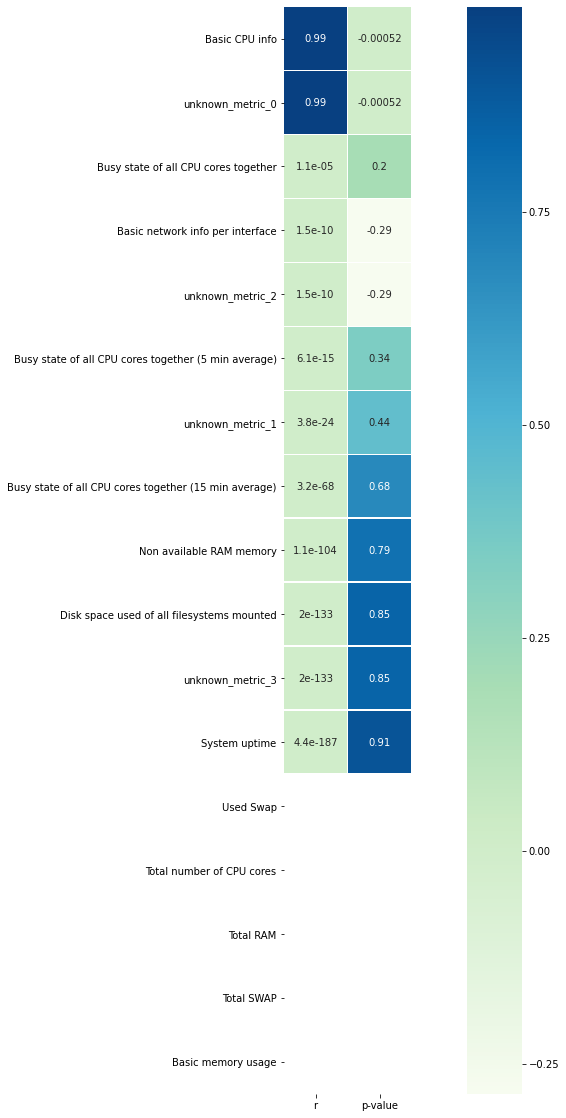

In [16]:
import seaborn as sns

txn_falure_correlation = pd.DataFrame.from_dict(correlation_txn_falure, orient='index').rename(columns={0:'r', 1:'p-value'}).sort_values('r', ascending=False)

plt.figure(figsize=(20,20))
sns.heatmap(txn_falure_correlation, cmap='GnBu', square=True, annot=True, linewidths=.5)

                                                   r   p-value
Basic network info per interface            0.389223 -0.039183
unknown_metric_2                            0.389223 -0.039183
System uptime                               0.037369  0.094558
Disk space used of all filesystems mounted  0.000004  0.207185
unknown_metric_3                            0.000004  0.207185


<AxesSubplot:>

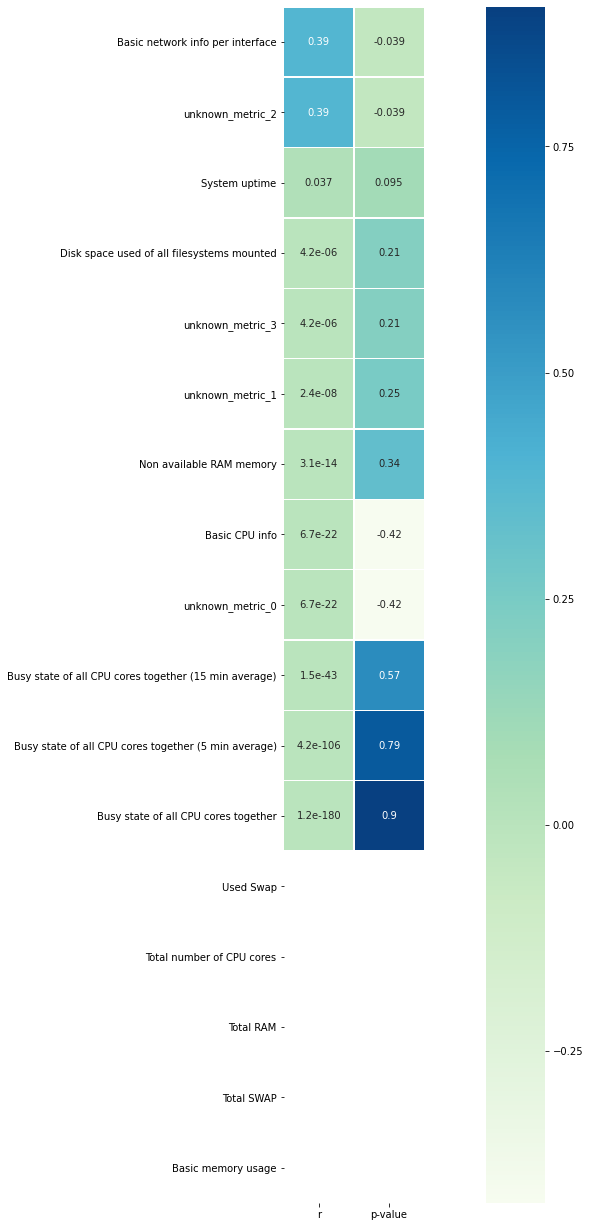

In [17]:
from scipy import stats
import pprint

correlation_txn_falure_bool = {}
for label in labels_to_correlate.columns:
    r,p = stats.pointbiserialr(labels_to_correlate[label], label_data.label)
    correlation_txn_falure_bool[label] = (p,r)
pointbiserialr = pd.DataFrame.from_dict(correlation_txn_falure_bool, orient='index').rename(columns={0:'r', 1:'p-value'}).sort_values('r', ascending=False)

print(pointbiserialr.head())
plt.figure(figsize=(22,22))
sns.heatmap(pointbiserialr, cmap='GnBu', square=True, annot=True, linewidths=.5)

<p style="color:red;">2 methods to calculate correlation, dont know which method is best for the data</p>

<AxesSubplot:>

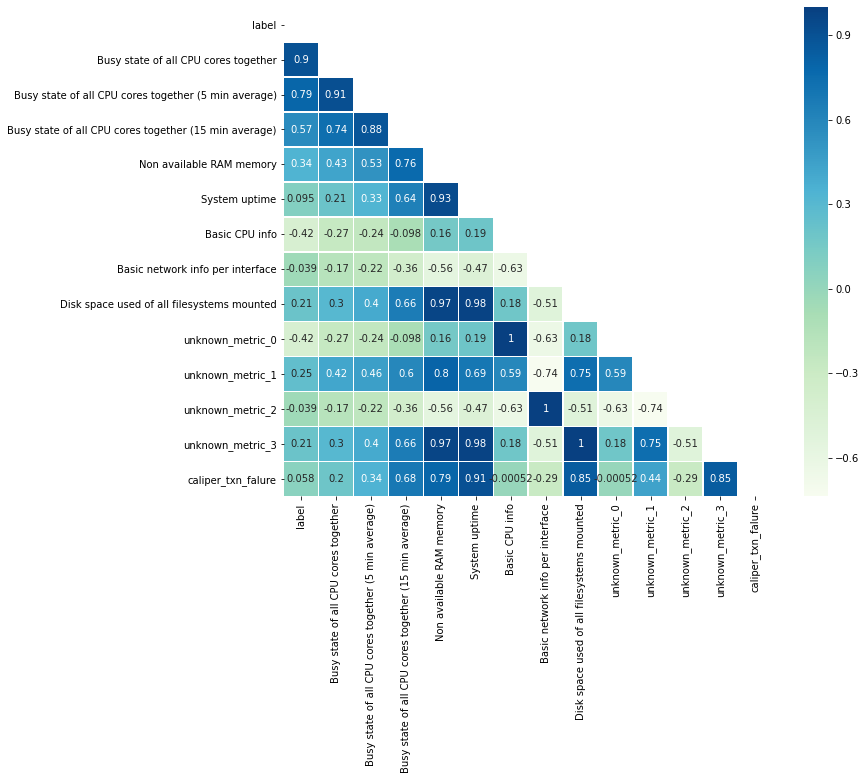

In [18]:
correlations = label_data.corr().dropna(axis=1, how='all').T.dropna(axis=1, how='all').T
# heatmap

matrix = np.triu(correlations)

plt.figure(figsize=(11,9))
sns.heatmap(correlations, cmap='GnBu', square=True, annot=True, linewidths=.5, mask=matrix)
#plt.savefig('xx.png')

In [19]:
label_data.head()

,time,label,Busy state of all CPU cores together,Busy state of all CPU cores together (5 min average),Busy state of all CPU cores together (15 min average),Non available RAM memory,Used Swap,Total number of CPU cores,System uptime,Total RAM,Total SWAP,Basic CPU info,Basic memory usage,Basic network info per interface,Disk space used of all filesystems mounted,unknown_metric_0,unknown_metric_1,unknown_metric_2,unknown_metric_3,caliper_txn_falure
0,2021-05-18 13:06:00,0,6.950000,4.25,21.25,23.388541,0.0,4.0,1.089743e+07,1.679186e+10,0.0,9.196610,1.679186e+10,1564.311864,37.241920,9.196610,9.249055e+08,1564.311864,1.155866e+10,12506.0
1,2021-05-18 13:06:15,0,7.016949,4.00,21.00,23.803510,0.0,4.0,1.089745e+07,1.679186e+10,0.0,9.213559,1.679186e+10,1568.650847,38.898826,9.213559,9.919160e+08,1568.650847,1.207291e+10,12506.0
2,2021-05-18 13:06:30,0,7.424576,3.75,20.50,17.132260,0.0,4.0,1.089746e+07,1.679186e+10,0.0,9.813559,1.679186e+10,1582.318644,35.703579,9.813559,1.085415e+09,1582.318644,1.108121e+10,12506.0
3,2021-05-18 13:06:45,1,8.510169,4.50,20.50,18.097213,0.0,4.0,1.089748e+07,1.679186e+10,0.0,11.227119,1.679186e+10,1580.040678,35.812509,11.227119,1.210036e+09,1580.040678,1.111502e+10,0.0
4,2021-05-18 13:07:00,0,10.101695,7.50,21.25,18.636683,0.0,4.0,1.089749e+07,1.679186e+10,0.0,13.088136,1.679186e+10,1577.762712,35.951873,13.088136,1.252499e+09,1577.762712,1.115827e+10,0.0


# Correlation analysis
<p style="color:red;">Use correlation with caliper_txn_falure or other metrics or both? Now use pearson correlation</p>

In [20]:
txn_falure_correlation

,r,p-value
Basic CPU info,9.908134e-01,-0.000524
unknown_metric_0,9.908134e-01,-0.000524
Busy state of all CPU cores together,1.147195e-05,0.197760
Basic network info per interface,1.487109e-10,-0.285570
unknown_metric_2,1.487109e-10,-0.285570
Busy state of all CPU cores together (5 min average),6.141157e-15,0.344231
unknown_metric_1,3.786564e-24,0.437969
Busy state of all CPU cores together (15 min average),3.188254e-68,0.684208
Non available RAM memory,1.135840e-104,0.789969
Disk space used of all filesystems mounted,2.010102e-133,0.845052


In [21]:
# drop unkonwn metrics looks like those are duplicates
df_index = list(txn_falure_correlation.index)
remove_from_index = [x for x in df_index if 'unknown_metric' in x]

txn_falure_correlation = txn_falure_correlation.drop(remove_from_index)
# drop Nan
txn_falure_correlation = txn_falure_correlation.dropna(axis='rows')

<p style="color:red;">How to justify threshold? </p>

In [22]:
selected_features = txn_falure_correlation[txn_falure_correlation.r >1.147195e-06]
selected_features_names = selected_features.index
selected_features

,r,p-value
Basic CPU info,0.990813,-0.000524
Busy state of all CPU cores together,0.000011,0.197760


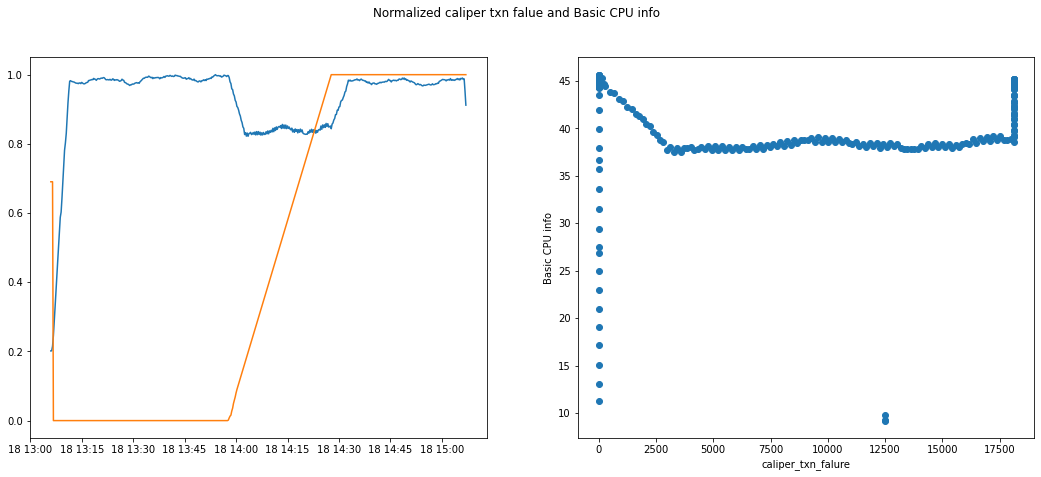

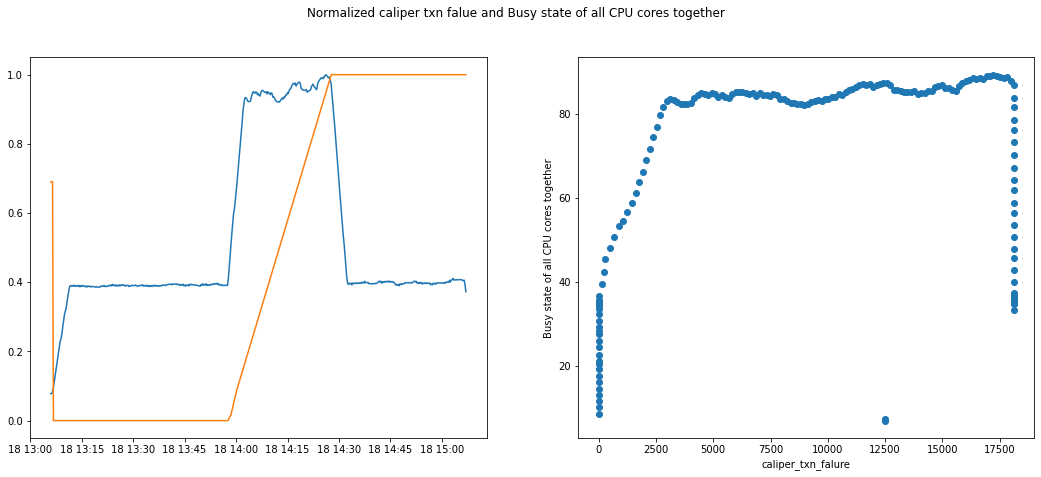

In [23]:
from sklearn.preprocessing import MinMaxScaler
normalized_label_data = label_data.copy()

for i in normalized_label_data.drop(['time'], axis=1).columns:  
    normalized_label_data[i]/=normalized_label_data[i].max()

for feature in selected_features_names:
    fig, ax =plt.subplots(figsize=(18,7))
    
    plt.subplot(1,2,1)
    plt.plot(normalized_label_data['time'], normalized_label_data[feature], label=feature)
    plt.plot(normalized_label_data['time'],normalized_label_data['caliper_txn_falure'],label='caliper_txn_falue')
    
    plt.subplot(1,2,2)
    plt.suptitle("Normalized caliper txn falue and "+feature)
    plt.scatter(label_data['caliper_txn_falure'], label_data[feature])
    plt.xlabel('caliper_txn_falure')
    plt.ylabel(feature)
#     plt.plot(normalized_label_data['time'],normalized_label_data['caliper_txn_falure'],label='caliper_txn_falue')
    plt.show()

# train test split

In [71]:
from sklearn.model_selection import train_test_split
# random state = 0 to preserve time series may change later. 
X_train,X_test, y_train, y_test = train_test_split(label_data.drop('label', axis=1), normalized_label_data.label, test_size=0.33, random_state=0)
# normalized_X_train,normalized_X_test, normalized_y_train, normalized_y_test = train_test_split(normalized_label_data.drop('label', axis=1), normalized_label_data.label, test_size=0.33, random_state=0)

y_train = y_train.to_frame()
y_train['time'] = X_train.time

X_train = X_train.reset_index()
y_train = y_train.reset_index()



# Isolation Forest

##### Isolation forest using most usefull metrics


In [109]:
to_model_columns=X_train.drop('time', axis=1).columns
df = label_data.drop(['time', 'label'], axis=1)

from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(df)

pred = clf.predict(df)

# Predict on Train set inappropriate way 
df['IF predictions']=pred
outliers=X_train.loc[df['IF predictions']==-1]
outlier_index=list(outliers.index)
print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(df['IF predictions'].value_counts())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 42, 208, 209, 210, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 232, 313]
 1    426
-1     59
Name: IF predictions, dtype: int64


# Plot isolation forest Outliers using PCA

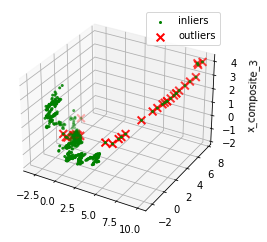

In [110]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()

#normalize the metrics
X = scaler.fit_transform(df)
X_reduce = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")

# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

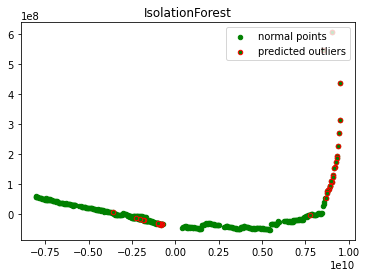

In [113]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(df)
res=pd.DataFrame(pca.transform(df))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

#### plot predictions on Basic CPU info metric

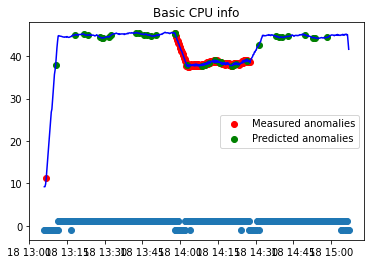

In [119]:
anomalies = [i for i,j in enumerate(label_data.label) if j]
anomalies

plt.scatter(label_data.time[anomalies], label_data['Basic CPU info'][anomalies], c='r', label='Measured anomalies')
plt.plot(label_data.time, label_data['Basic CPU info'], c='b')
plt.scatter(outliers.time, outliers['Basic CPU info'][outlier_index], c='g', label='Predicted anomalies')
plt.scatter(label_data.time, pred)
plt.title('Basic CPU info')
plt.legend()
plt.show()

In [115]:
# TODO accuracy, ROC, 


,index,time,Busy state of all CPU cores together,Busy state of all CPU cores together (5 min average),Busy state of all CPU cores together (15 min average),Non available RAM memory,Used Swap,Total number of CPU cores,System uptime,Total RAM,...,Basic CPU info,Basic memory usage,Basic network info per interface,Disk space used of all filesystems mounted,unknown_metric_0,unknown_metric_1,unknown_metric_2,unknown_metric_3,caliper_txn_falure,IF predictions
0,208,2021-05-18 13:58:00,39.564407,120.00,117.50,91.213067,0.0,4.0,1.090055e+07,1.679186e+10,...,45.277966,1.679186e+10,1513.003390,72.121699,45.277966,1.697853e+09,1513.003390,2.238419e+10,139.0,-1
1,281,2021-05-18 14:16:15,86.561017,325.00,265.75,92.347062,0.0,4.0,1.090165e+07,1.679186e+10,...,38.600000,1.679186e+10,1528.786441,73.044202,38.600000,1.699328e+09,1528.786441,2.267050e+10,11227.0,1
2,322,2021-05-18 14:26:30,89.067797,334.75,300.50,92.614309,0.0,4.0,1.090226e+07,1.679186e+10,...,38.820339,1.679186e+10,1527.484746,74.912159,38.820339,1.698210e+09,1527.484746,2.325025e+10,17378.0,1
3,164,2021-05-18 13:47:00,35.227119,120.75,112.75,67.016126,0.0,4.0,1.089989e+07,1.679186e+10,...,45.013559,1.679186e+10,1522.061017,60.007158,45.013559,1.657479e+09,1522.061017,1.862423e+10,0.0,1
4,106,2021-05-18 13:32:30,34.905085,136.00,98.75,50.241635,0.0,4.0,1.089902e+07,1.679186e+10,...,44.949153,1.679186e+10,1531.389831,51.069851,44.949153,1.635516e+09,1531.389831,1.585039e+10,0.0,1
5,449,2021-05-18 14:58:15,35.247458,76.50,124.75,99.011922,0.0,4.0,1.090417e+07,1.679186e+10,...,44.474576,1.679186e+10,1526.291525,88.385716,44.474576,1.708929e+09,1526.291525,2.743200e+10,18114.0,1
6,63,2021-05-18 13:21:45,34.647458,97.75,75.75,37.543761,0.0,4.0,1.089838e+07,1.679186e+10,...,45.159322,1.679186e+10,1538.115254,44.218507,45.159322,1.578541e+09,1538.115254,1.372396e+10,0.0,1
7,387,2021-05-18 14:42:45,35.893220,170.25,211.50,98.907985,0.0,4.0,1.090324e+07,1.679186e+10,...,44.671186,1.679186e+10,1523.688136,80.316606,44.671186,1.701556e+09,1523.688136,2.492761e+10,18114.0,1
8,415,2021-05-18 14:49:45,35.606780,96.75,162.75,98.784972,0.0,4.0,1.090366e+07,1.679186e+10,...,44.911864,1.679186e+10,1522.928814,83.426651,44.911864,1.704301e+09,1522.928814,2.589287e+10,18114.0,1
9,427,2021-05-18 14:52:45,35.520094,85.50,146.50,98.502967,0.0,4.0,1.090384e+07,1.679186e+10,...,44.373633,1.679186e+10,1538.792183,85.293051,44.373633,1.705861e+09,1538.792183,2.647214e+10,18114.0,1


In [117]:
predictions 

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1,  1

In [169]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
def plot_anomaly(df,metric_name):
    df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y%m%d")
    dates = df.load_date
    #identify the anomaly points and create a array of its values for plot
    bool_array = (abs(df['anomaly']) > 0)
    actuals = df["actuals"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
    #A dictionary for conditional format table based on anomaly
    color_map = {0: "'rgba(228, 222, 249, 0.65)'", 1: "yellow", 2: "red"}
    
    #Table which includes Date,Actuals,Change occured from previous point
    table = go.Table(
        domain=dict(x=[0, 1],
                    y=[0, 0.3]),
        columnwidth=[1, 2],
        # columnorder=[0, 1, 2,],
        header=dict(height=20,
                    values=[['<b>Date</b>'], ['<b>Actual Values </b>'], ['<b>% Change </b>'],
                            ],
                    font=dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                    fill=dict(color='#d562be')),
        cells=dict(values=[df.round(3)[k].tolist() for k in ['load_date', 'actuals', 'percentage_change']],
                   line=dict(color='#506784'),
                   align=['center'] * 5,
                   font=dict(color=['rgb(40, 40, 40)'] * 5, size=12),
                   # format = [None] + [",.4f"] + [',.4f'],
                   # suffix=[None] * 4,
                   suffix=[None] + [''] + [''] + ['%'] + [''],
                   height=27,
                   fill=dict(color=[test_df['anomaly_class'].map(color_map)],#map based on anomaly level from dictionary
                   )
                   ))
    #Plot the actuals points
    Actuals = go.Scatter(name='Actuals',
                         x=dates,
                         y=df['actuals'],
                         xaxis='x1', yaxis='y1',
                         mode='lines',
                         marker=dict(size=12,
                                     line=dict(width=1),
                                     color="blue"))
#Highlight the anomaly points
    anomalies_map = go.Scatter(name="Anomaly",
                               showlegend=True,
                               x=dates,
                               y=anomaly_points,
                               mode='markers',
                               xaxis='x1',
                               yaxis='y1',
                               marker=dict(color="red",
                                           size=11,
                                           line=dict(
                                               color="red",
                                               width=2)))
axis = dict(
        showline=True,
        zeroline=False,
        showgrid=True,
        mirror=True,
        ticklen=4,
        gridcolor='#ffffff',
        tickfont=dict(size=10))
layout = dict(
        width=1000,
        height=865,
        autosize=False,
        title=metric_name,
        margin=dict(t=75),
        showlegend=True,
        xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
        yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20, 1], anchor='x1', hoverformat='.2f')))
fig = go.Figure(data=[table, anomalies_map, Actuals], layout=layout)
iplot(fig)
pyplot.show()

ImportError: 
The plotly.plotly module is deprecated,
please install the chart-studio package and use the
chart_studio.plotly module instead. 


In [170]:
def classify_anomalies(df,metric_name):
    df['metric_name']=metric_name
    df = df.sort_values(by='load_date', ascending=False)
    #Shift actuals by one timestamp to find the percentage chage between current and previous data point
    df['shift'] = df['actuals'].shift(-1)
    df['percentage_change'] = ((df['actuals'] - df['shift']) / df['actuals']) * 100
    #Categorise anomalies as 0-no anomaly, 1- low anomaly , 2 - high anomaly
    df['anomaly'].loc[df['anomaly'] == 1] = 0
    df['anomaly'].loc[df['anomaly'] == -1] = 2
    df['anomaly_class'] = df['anomaly']
    max_anomaly_score = df['score'].loc[df['anomaly_class'] == 2].max()
    medium_percentile = df['score'].quantile(0.24)
    df['anomaly_class'].loc[(df['score'] > max_anomaly_score) & (df['score'] <= medium_percentile)] = 1
    return df

In [171]:
import warnings  
metrics_df = df
metrics_df['time'] = label_data['time']

warnings.filterwarnings('ignore')
for i in range(1,len(metrics_df.columns)-1):
    clf.fit(metrics_df.iloc[:,i:i+1])
    pred = clf.predict(metrics_df.iloc[:,i:i+1])
    test_df=pd.DataFrame()
    test_df['load_date']=metrics_df['time']
    #Find decision function to find the score and classify anomalies
    test_df['score']=clf.decision_function(metrics_df.iloc[:,i:i+1])
    test_df['actuals']=metrics_df.iloc[:,i:i+1]
    test_df['anomaly']=pred
    #Get the indexes of outliers in order to compare the metrics     with use case anomalies if required
    outliers=test_df.loc[test_df['anomaly']==-1]
    outlier_index=list(outliers.index)
    test_df=classify_anomalies(test_df,metrics_df.columns[i])
    plot_anomaly(test_df,metrics_df.columns[i])